# **Imports**

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sa
import statsmodels.formula.api as sfa

import re

from IPython.display import Markdown

# **Helper Functions**

In [19]:
def anova(dataframe, discrete_column_name, categorical_column_name, type = 'DEFAULT'):
  if type == 'DEFAULT':
    F, p = stats.f_oneway(dataframe[discrete_column_name][dataframe[categorical_column_name] == 0], dataframe[discrete_column_name][dataframe[categorical_column_name] == 1])
  if type == 'RACE':
    F, p = stats.f_oneway(dataframe[discrete_column_name][df[categorical_column_name] == 'Black'], 
                          dataframe[discrete_column_name][df[categorical_column_name] == 'White'],
                          dataframe[discrete_column_name][df[categorical_column_name] == 'Asian'],
                          dataframe[discrete_column_name][df[categorical_column_name] == 'Native American'],
                          dataframe[discrete_column_name][df[categorical_column_name] == 'Unknown'])  
  return round(p, 3)

def chi_square(dataframe, col1_name, col2_name, type):
  if type == '2x2':
    df1 = dataframe[dataframe[col1_name] == 1]
    df0 = dataframe[dataframe[col1_name] == 0]
    data = [[len(df1[df1[col2_name] == 1]), len(df1[df1[col2_name] == 0])], 
            [len(df0[df0[col2_name] == 1]), len(df0[df0[col2_name] == 0])]] 
  if type == 'RACE':
    dfb = dataframe[dataframe[col1_name] == 'Black']
    dfw = dataframe[dataframe[col1_name] == 'White']
    dfa = dataframe[dataframe[col1_name] == 'Asian']
    dfi = dataframe[dataframe[col1_name] == 'Native American']
    dfu = dataframe[dataframe[col1_name] == 'Unknown']
    data = [[len(dfb[dfb[col2_name] == 1]), len(dfb[dfb[col2_name] == 0])],
            [len(dfw[dfw[col2_name] == 1]), len(dfw[dfw[col2_name] == 0])],
            [len(dfa[dfa[col2_name] == 1]), len(dfa[dfa[col2_name] == 0])],
            [len(dfi[dfi[col2_name] == 1]), len(dfi[dfi[col2_name] == 0])],
            [len(dfu[dfu[col2_name] == 1]), len(dfu[dfu[col2_name] == 0])]] 
  stat, p, dof, expected = stats.chi2_contingency(data) 
  return round(p, 3)

def pearson(dataframe, col1_name, col2_name):
  r, p = stats.pearsonr(dataframe[col1_name], dataframe[col2_name])
  return round(p, 3)

def univariable_regression(dataframe, colx_name, coly_name, type):
  if type == 'LOGISTIC':
    mod = sa.Logit(dataframe[coly_name], sa.add_constant(dataframe[[colx_name]]))
  if type == 'LINEAR':
    mod = sa.OLS(dataframe[coly_name], sa.add_constant(dataframe[[colx_name]]))
  res = mod.fit(disp=0)
  return round(np.exp(res.params), 2), round(np.exp(res.conf_int()), 2), round(res.pvalues, 3)

def multivariable_regression(dataframe, colx_names, coly_name, type):
  if type == 'LOGISTIC':
    mod = sa.Logit(dataframe[coly_name], sa.add_constant(dataframe[colx_names]))
  if type == 'LINEAR':
    mod = sa.OLS(dataframe[coly_name], sa.add_constant(dataframe[colx_names]))
  res = mod.fit(disp=0)
  mul_table = round(np.exp(res.conf_int()), 2)
  mul_table['OR'] = round(np.exp(res.params), 2)
  mul_table['P'] = round(res.pvalues, 3)
  mul_table.columns = ['5%', '95%', 'OR', 'P']
  return mul_table

def pearson_corr_matrix(corr, mask=None, columns=[]):
    f, ax = plt.subplots(figsize=(5, 3))
    heatmap = sns.heatmap(corr, ax=ax, fmt=".1g", mask=mask, annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'vertical'},
                xticklabels=columns, yticklabels=columns)
    fig = heatmap.get_figure()
    #fig.savefig('Corr.eps', bbox_inches='tight')
    plt.show()
    
def boxplot(dataframe, colx_name, coly_name, xlabel, ylabel, name):
    dataframe_copy = dataframe[[colx_name, coly_name]].copy()
    if colx_name != 'RACE':  
      dataframe_copy[colx_name].replace(to_replace = [0], value = 'No', inplace = True) 
      dataframe_copy[colx_name].replace(to_replace = [1], value = 'Yes', inplace = True) 
    boxplot = sns.boxplot(x=colx_name, y=coly_name, palette=["m", "g"], data=dataframe_copy)
    boxplot.set(xlabel=xlabel, ylabel=ylabel)
    fig = boxplot.get_figure()
    #fig.savefig(name)
    sns.despine(offset=10, trim=True)
    plt.show()


# **Model Loading**

In [13]:
filepath = "hospitalized_patients_covid_19_bahia_Jun292020-EN.csv"
df = pd.read_csv(filepath)

# **Table 1**

In [14]:
df_death = df[df['DEATH OUTCOME'] == 1]
df_recovery = df[df['DEATH OUTCOME'] == 0]

def describe_column(dataframe, column_name, type, value = 0):
  if type == 'DISCRETE':
    return str(round(df_death[column_name].mean(), 1)) + str(" (" + str(round(df_death[column_name].std(), 1)) + ")"), str(round(df_recovery[column_name].mean(), 1)) + str(" (" + str(round(df_recovery[column_name].std(), 1)) + ")")
  if type == 'CATEGORICAL':
    return str(len(df_death[df_death[column_name] == value])) + str(" (" + str(round((len(df_death[df_death[column_name] == value])/len(df_death))*100, 1)) + ")"), str(len(df_recovery[df_recovery[column_name] == value])) + str(" (" + str(round((len(df_recovery[df_recovery[column_name] == value])/len(df_recovery))*100, 1)) + ")")

died, recovered = describe_column(df, 'AGE', 'DISCRETE')
P = anova(df, 'AGE', 'DEATH OUTCOME')
overview_data = {'name' : ['Age'], 'Died' : died, 'Recovered' : recovered, 'P' : P}
overview_table = pd.DataFrame(overview_data)
P = chi_square(df, 'SEX', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'Sex', 'Died' : '--', 'Recovered' : '--', 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'SEX', 'CATEGORICAL', 1)
overview_table = overview_table.append({'name' : 'Female', 'Died' : died, 'Recovered' : recovered, 'P' : '--'}, ignore_index=True)
died, recovered = describe_column(df, 'SEX', 'CATEGORICAL', 0)
overview_table = overview_table.append({'name' : 'Male', 'Died' : died, 'Recovered' : recovered, 'P' : '--'}, ignore_index=True)
P = chi_square(df, 'RACE', 'DEATH OUTCOME', 'RACE')
overview_table = overview_table.append({'name' : 'Race', 'Died' : '--', 'Recovered' : '--', 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'RACE', 'CATEGORICAL', 'Black')
overview_table = overview_table.append({'name' : 'Black', 'Died' : died, 'Recovered' : recovered, 'P' : '--'}, ignore_index=True)
died, recovered = describe_column(df, 'RACE', 'CATEGORICAL', 'White')
overview_table = overview_table.append({'name' : 'White', 'Died' : died, 'Recovered' : recovered, 'P' : '--'}, ignore_index=True)
died, recovered = describe_column(df, 'RACE', 'CATEGORICAL', 'Asian')
overview_table = overview_table.append({'name' : 'Asian', 'Died' : died, 'Recovered' : recovered, 'P' : '--'}, ignore_index=True)
died, recovered = describe_column(df, 'RACE', 'CATEGORICAL', 'Native American')
overview_table = overview_table.append({'name' : 'Native American', 'Died' : died, 'Recovered' : recovered, 'P' : '--'}, ignore_index=True)
died, recovered = describe_column(df, 'RACE', 'CATEGORICAL', 'Unknown')
overview_table = overview_table.append({'name' : 'Unknown', 'Died' : died, 'Recovered' : recovered, 'P' : '--'}, ignore_index=True)
overview_table = overview_table.append({'name' : 'Symptoms', 'Died' : '--', 'Recovered' : '--', 'P' : '--'}, ignore_index=True)
died, recovered = describe_column(df, 'SORE THROAT', 'CATEGORICAL', 1)
P = chi_square(df, 'SORE THROAT', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'Sore Throat', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'SHORTNESS OF BREATH', 'CATEGORICAL', 1)
P = chi_square(df, 'SHORTNESS OF BREATH', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'Shortness of Breath', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'FEVER', 'CATEGORICAL', 1)
P = chi_square(df, 'FEVER', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'Fever', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'COUGH', 'CATEGORICAL', 1)
P = chi_square(df, 'COUGH', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'Cough', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
overview_table = overview_table.append({'name' : 'Comorbidities', 'Died' : '--', 'Recovered' : '--', 'P' : '--'}, ignore_index=True)
died, recovered = describe_column(df, 'DIABETES', 'CATEGORICAL', 1)
P = chi_square(df, 'DIABETES', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'Diabetes', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'IMMUNOSUPPRESION', 'CATEGORICAL', 1)
P = chi_square(df, 'IMMUNOSUPPRESION', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'Immunosuppresion', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'CHRONIC KIDNEY DISEASE', 'CATEGORICAL', 1)
P = chi_square(df, 'CHRONIC KIDNEY DISEASE', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'Chronic Kidney Disease', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'CHRONIC RESPIRATORY DISEASE', 'CATEGORICAL', 1)
P = chi_square(df, 'CHRONIC RESPIRATORY DISEASE', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'Chronic Respiratory Disease', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'CARDIOVASCULAR DISEASE', 'CATEGORICAL', 1)
P = chi_square(df, 'CARDIOVASCULAR DISEASE', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'Cardiovascular Disease', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'CHROMOSOMAL DISORDER', 'CATEGORICAL', 1)
P = chi_square(df, 'CHROMOSOMAL DISORDER', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'Chromosomal Disorder', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
overview_table = overview_table.append({'name' : 'Others', 'Died' : '--', 'Recovered' : '--', 'P' : '--'}, ignore_index=True)
died, recovered = describe_column(df, 'LOW-RISK PREGNANCY', 'CATEGORICAL', 1)
P = chi_square(df, 'LOW-RISK PREGNANCY', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'Low-risk Pregnancy', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'HIGH-RISK PREGNANCY', 'CATEGORICAL', 1)
P = chi_square(df, 'HIGH-RISK PREGNANCY', 'DEATH OUTCOME', '2x2')
overview_table = overview_table.append({'name' : 'High-risk Pregnancy', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'LENGTH OF HOSPITAL STAY', 'DISCRETE')
P = anova(df, 'LENGTH OF HOSPITAL STAY', 'DEATH OUTCOME')
overview_table = overview_table.append({'name' : 'Length of Hospital Stay', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
died, recovered = describe_column(df, 'TIME FROM DIAGNOSIS TO FINAL OUTCOME', 'DISCRETE')
P = anova(df, 'TIME FROM DIAGNOSIS TO FINAL OUTCOME', 'DEATH OUTCOME')
overview_table = overview_table.append({'name' : 'Time from Diagnosis to Definitive Outcome', 'Died' : died, 'Recovered' : recovered, 'P' : P}, ignore_index=True)
print(overview_table.to_string(index = False))

                                      name         Died    Recovered      P
                                       Age  68.8 (15.9)  57.7 (18.9)      0
                                       Sex           --           --  0.802
                                    Female   414 (39.6)  1144 (40.1)     --
                                      Male   631 (60.4)  1707 (59.9)     --
                                      Race           --           --  0.128
                                     Black   682 (65.3)  1803 (63.2)     --
                                     White   107 (10.2)   381 (13.4)     --
                                     Asian   147 (14.1)   370 (13.0)     --
                           Native American      2 (0.2)      5 (0.2)     --
                                   Unknown   107 (10.2)   292 (10.2)     --
                                  Symptoms           --           --     --
                               Sore Throat   109 (10.4)   432 (15.2)      0
            

# **Table 2**

In [15]:
columns = ['AGE', 'SORE THROAT', 'SHORTNESS OF BREATH', 'DIABETES', 'CHRONIC KIDNEY DISEASE', 
                             'CHRONIC RESPIRATORY DISEASE', 'CARDIOVASCULAR DISEASE', 'LOW-RISK PREGNANCY',
                             'LENGTH OF HOSPITAL STAY', 'TIME FROM DIAGNOSIS TO FINAL OUTCOME']
                             
print('Univariable Results (Mortality)')
for col in columns:
  OR, CI, p = univariable_regression(df, col, 'DEATH OUTCOME', 'LOGISTIC')
  if col == 'AGE':
    uni_data = {'name' : ['Age'], 'OR' : [OR[1]], '5%' : [CI[0][1]], '95%' : [CI[1][1]], 'P' : [p[1]]}
    uni_table = pd.DataFrame(uni_data)
  else:
    uni_table = uni_table.append({'name' : col, 'OR' : OR[1], '5%' : CI[0][1], '95%' : CI[1][1], 'P' : p[1]}, ignore_index=True)
print(uni_table.to_string(index = False))

print()

print('Multivariable Results (Mortality)')
multi_table = multivariable_regression(df, columns, 'DEATH OUTCOME', 'LOGISTIC')
multi_table = multi_table[['OR', "5%", "95%", "P"]]
multi_table = multi_table.drop(multi_table.index[[0]])
print(multi_table)

Univariable Results (Mortality)
                                 name    OR    5%   95%      P
                                  Age  1.04  1.03  1.04  0.000
                          SORE THROAT  0.65  0.52  0.82  0.000
                  SHORTNESS OF BREATH  2.26  1.95  2.61  0.000
                             DIABETES  1.54  1.30  1.81  0.000
               CHRONIC KIDNEY DISEASE  2.27  1.64  3.15  0.000
          CHRONIC RESPIRATORY DISEASE  1.64  1.22  2.22  0.001
               CARDIOVASCULAR DISEASE  1.40  1.19  1.65  0.000
                   LOW-RISK PREGNANCY  0.22  0.08  0.61  0.004
              LENGTH OF HOSPITAL STAY  0.93  0.92  0.94  0.000
 TIME FROM DIAGNOSIS TO FINAL OUTCOME  0.93  0.92  0.94  0.000

Multivariable Results (Mortality)
                                        OR    5%   95%      P
AGE                                   1.03  1.03  1.04  0.000
SORE THROAT                           0.74  0.58  0.95  0.016
SHORTNESS OF BREATH                   1.88  1.60  2.20

# **Table 3**

In [16]:
lhs = 'LENGTH OF HOSPITAL STAY'
tdfo = 'TIME FROM DIAGNOSIS TO FINAL OUTCOME'
excluded_columns = ['AGE', 'DEATH OUTCOME', 'RACE', lhs, tdfo]

overview2_data = {'name' : ['AGE'], 'P (Length of Hospital Stay)' : pearson(df, 'AGE', lhs), 'P (Time from Diag. to Def. Out.)' : pearson(df, 'AGE', tdfo)}
overview2_table = pd.DataFrame(overview2_data)

for col in df.columns:
  if col not in excluded_columns:
    P_lhs = anova(df, lhs, col)
    P_tdfo = anova(df, tdfo, col)
    overview2_table = overview2_table.append({'name' : col, 'P (Length of Hospital Stay)' : P_lhs, 'P (Time from Diag. to Def. Out.)' : P_tdfo}, ignore_index=True)
P_lhs = anova(df, lhs, 'RACE', 'RACE')
P_tdfo = anova(df, tdfo, 'RACE', 'RACE')
overview2_table = overview2_table.append({'name' : 'RACE', 'P (Length of Hospital Stay)' : P_lhs, 'P (Time from Diag. to Def. Out.)' : P_tdfo}, ignore_index=True)
P_lhs = pearson(df, lhs, lhs)
P_tdfo = pearson(df, lhs, tdfo)
overview2_table = overview2_table.append({'name' : lhs, 'P (Length of Hospital Stay)' : P_lhs, 'P (Time from Diag. to Def. Out.)' : P_tdfo}, ignore_index=True)
P_lhs = pearson(df, tdfo, lhs)
P_tdfo = pearson(df, tdfo, tdfo)
overview2_table = overview2_table.append({'name' : tdfo, 'P (Length of Hospital Stay)' : P_lhs, 'P (Time from Diag. to Def. Out.)' : P_tdfo}, ignore_index=True)
print(overview2_table.to_string(index = False))

                                 name  P (Length of Hospital Stay)  P (Time from Diag. to Def. Out.)
                                  AGE                        0.000                             0.000
                                  SEX                        0.546                             0.213
                  SHORTNESS OF BREATH                        0.000                             0.000
                          SORE THROAT                        0.438                             0.109
                                FEVER                        0.346                             0.298
                                COUGH                        0.641                             0.018
          CHRONIC RESPIRATORY DISEASE                        0.070                             0.163
               CARDIOVASCULAR DISEASE                        0.422                             0.216
               CHRONIC KIDNEY DISEASE                        0.905                         

# **Table 4**

In [17]:
columns = ['AGE', 'RACE_Black', 'RACE_White', 'RACE_Asian', 'RACE_Native American', 'RACE_Unknown', 'SHORTNESS OF BREATH', 'LOW-RISK PREGNANCY', 'TIME FROM DIAGNOSIS TO FINAL OUTCOME']

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

print('Univariable Results (Length of Hospital Stay)')
df_race = df
df_race = encode_and_bind(df_race, 'RACE')
for col in columns:
  OR, CI, p = univariable_regression(df_race, col, 'LENGTH OF HOSPITAL STAY', 'LINEAR')
  if col == 'AGE':
    uni_data = {'name' : ['Age'], 'OR' : [OR[1]], '5%' : [CI[0][1]], '95%' : [CI[1][1]], 'P' : [p[1]]}
    uni_table = pd.DataFrame(uni_data)
  else:
    uni_table = uni_table.append({'name' : col, 'OR' : OR[1], '5%' : CI[0][1], '95%' : CI[1][1], 'P' : p[1]}, ignore_index=True)
print(uni_table.to_string(index = False))

print()

print('Multivariable Results (Length of Hospital Stay)')
multi_table = multivariable_regression(df_race, columns, 'LENGTH OF HOSPITAL STAY', 'LINEAR')
multi_table = multi_table[['OR', "5%", "95%", "P"]]
multi_table = multi_table.drop(multi_table.index[[0]])
print(multi_table)

Univariable Results (Length of Hospital Stay)
                                 name       OR      5%       95%      P
                                  Age     0.92    0.90      0.94  0.000
                           RACE_Black     0.16    0.07      0.33  0.000
                           RACE_White     0.85    0.29      2.52  0.772
                           RACE_Asian     0.18    0.06      0.51  0.001
                 RACE_Native American     2.97    0.00  14113.75  0.801
                         RACE_Unknown  1090.42  341.08   3486.09  0.000
                  SHORTNESS OF BREATH     0.26    0.13      0.54  0.000
                   LOW-RISK PREGNANCY   153.69    6.98   3383.61  0.001
 TIME FROM DIAGNOSIS TO FINAL OUTCOME     1.70    1.66      1.74  0.000

Multivariable Results (Length of Hospital Stay)
                                         OR    5%      95%      P
AGE                                    0.97  0.96     0.99  0.000
RACE_Black                             0.63  0.19    

# **Pearson Correlation Matrix + Box Plots**

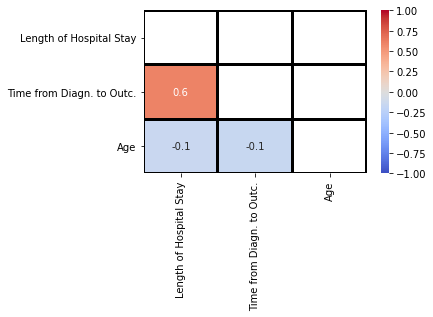

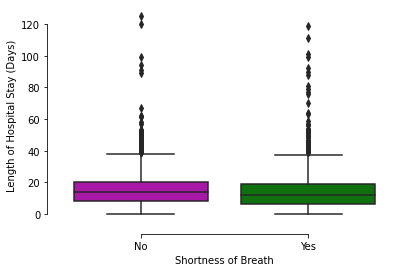

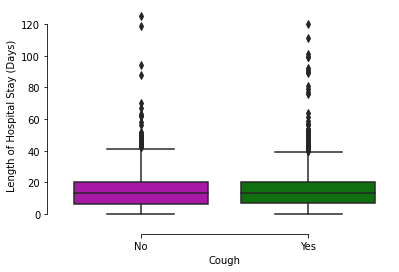

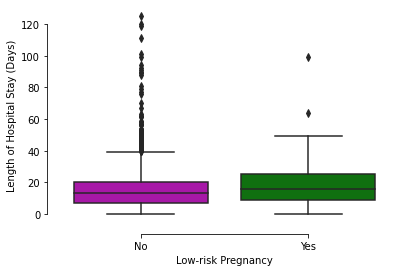

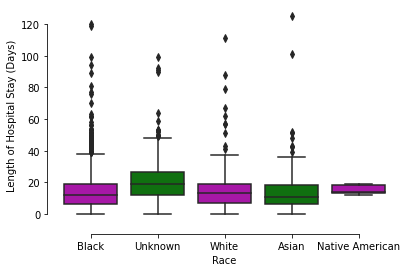

In [18]:
df_corr = df[['LENGTH OF HOSPITAL STAY', 'TIME FROM DIAGNOSIS TO FINAL OUTCOME', 'AGE']].copy()
corr = df_corr.corr()
mask = np.triu(corr)
pearson_corr_matrix(corr, mask, columns=['Length of Hospital Stay', 'Time from Diagn. to Outc.', 'Age'])

boxplot(df, 'SHORTNESS OF BREATH', 'LENGTH OF HOSPITAL STAY', 'Shortness of Breath', 'Length of Hospital Stay (Days)', 'ShortnessOfBreath.eps')
boxplot(df, 'COUGH', 'LENGTH OF HOSPITAL STAY', 'Cough', 'Length of Hospital Stay (Days)', 'Cough.eps')
boxplot(df, 'LOW-RISK PREGNANCY', 'LENGTH OF HOSPITAL STAY', 'Low-risk Pregnancy', 'Length of Hospital Stay (Days)', 'LowRiskPregnancy.eps')
boxplot(df, 'RACE', 'LENGTH OF HOSPITAL STAY', 'Race', 'Length of Hospital Stay (Days)', 'Race.eps')